In [ ]:
%pip install OSMPythonTools

In [ ]:
%pip install shapely

In [ ]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import requests
from shapely.geometry import shape
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union

from OSMPythonTools.api import Api
from OSMPythonTools.overpass import Overpass
from OSMPythonTools.nominatim import Nominatim

# import random
# from shapely.geometry import Point, LineString
# from shapely.ops import unary_union
# from shapely import offset_curve
# from dotenv import load_dotenv
# import requests

%matplotlib inline
pd.set_option('display.max_columns', None)  # Show all columns

ModuleNotFoundError: No module named 'OSMPythonTools'

In [3]:
def fetch_osm_features(area_name, tags, element_types=('way', 'relation')):
    """
    Query Overpass API for given tag-value pairs within a named area.
    Args:
        tags (dict): Dictionary of tag-value pairs to query.
        area_name (str): OSM area name to search within.
        element_types (tuple): Tuple of element types to fetch (e.g., ('way', 'relation')).  
    Returns:
        gpd.GeoDataFrame: GeoDataFrame of geometries with attributes.
    """
    
    overpass_url = "https://overpass-api.de/api/interpreter"

    # Build Overpass tag filter for specified element types
    tag_filters = "\n".join(
        f'  {etype}["{k}"="{v}"](area.searchArea);'
        for etype in element_types
        for k, v in tags.items()
    )

    # Build full query
    overpass_query = f"""
    [out:json][timeout:300];
    area["name"="{area_name}"]->.searchArea;
    (
    {tag_filters}
    );
    out body;
    >;
    out skel qt;
    """

    # Query Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    # Split OSM elements by type
    nodes = {}
    ways = []
    relations = []

    for el in data['elements']:
        if el['type'] == 'node':
            nodes[el['id']] = (el['lon'], el['lat'])
        elif el['type'] == 'way':
            ways.append(el)
        elif el['type'] == 'relation':
            relations.append(el)

     # Build geometries from ways
    features = []
    if 'way' in element_types:
        for way in ways:
            try:
                coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                
                if len(coords) > 0:  # Make sure we have valid coordinates
                    if coords[0] == coords[-1]:  # Closed polygon
                        geometry = Polygon(coords)
                    else:  # LineString if not closed
                        geometry = LineString(coords)
                    features.append({
                        'id': way['id'],
                        'tags': way.get('tags', {}),
                        'geometry': geometry
                    })
            except KeyError:
                continue  # Incomplete geometry, skip

    # Handle relations if needed
    if 'relation' in element_types:
        for relation in relations:
            try:
                coords = []
                for member in relation['members']:
                    if member['type'] == 'way' and member['ref'] in ways:
                        # Fetch way and add its coordinates
                        way = next(w for w in ways if w['id'] == member['ref'])
                        way_coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                        
                        if way_coords:  # Only add coordinates if they are valid
                            coords.extend(way_coords)

                if len(coords) > 0:  # Ensure coords is not empty
                    if coords[0] == coords[-1]:  # Closed polygon
                        geometry = Polygon(coords)
                    else:  # LineString if not closed
                        geometry = LineString(coords)

                    features.append({
                        'id': relation['id'],
                        'tags': relation.get('tags', {}),
                        'geometry': geometry
                    })
            except KeyError:
                continue  # Skip incomplete relations


    # Build GeoDataFrame
    gdf = gpd.GeoDataFrame(features, geometry='geometry', crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=27700)

    # Convert Linestrings to Polygons
    def close_and_convert(ls):
        if ls.coords[0] != ls.coords[-1]:
            coords = list(ls.coords)
            coords.append(coords[0])  # Force close
            return Polygon(coords)
        return Polygon(ls.coords)

    # Apply only to LineStrings
    gdf['geometry'] = gdf['geometry'].apply(
        lambda geom: close_and_convert(geom) if isinstance(geom, LineString) else geom
    )

    # Flatten tags into columns
    if not gdf.empty:
        tags_df = pd.json_normalize(gdf['tags'])
        gdf = pd.concat([gdf.drop(columns='tags'), tags_df], axis=1)

    return gdf

In [ ]:
# This section is to fetch the features from the expected tags
tags_1 = [
    {"leisure": "park", "access": "public"},
    {"leisure": "nature_reserve", "access": "public"},
    {"leisure": "garden", "access": "public"},
    {"boundary": "protected_area"}
    # ,{"natural": "wood", "access": "public"}
]
names = ["parks", "nature_reserves", "gardens", "protected_areas", "woods"]

features_1 = {}
for idx, group in enumerate(tags_1):
    group_name = f"gdf_{names[idx]}"
    print(f"Fetching group: {group_name}...")
    gdf_group = fetch_osm_features("United Kingdom", group, element_types=("way", "relation"))
    print(f"Fetched. Total features: {len(gdf_group)}")
    features_1[group_name] = gdf_group

Fetching group: gdf_parks...
Fetched. Total features: 37463
Fetching group: gdf_nature_reserves...
Fetched. Total features: 8163
Fetching group: gdf_gardens...
Fetched. Total features: 288815
Fetching group: gdf_protected_areas...
Fetched. Total features: 20450


In [25]:
features_1_filtered = {}

min_area_m2 = 1_000_000

for name, gdf in features_1.items():
    gdf = gdf.copy()
    gdf['area_m2'] = gdf.geometry.area

    print(f"Filtering {name}...")
    filtered_gdf = gdf[gdf['area_m2'] >= min_area_m2]
    print(f"Filtered parks (> {min_area_m2:,} m²): {len(filtered_gdf)}")

    features_1_filtered[f"{name}_filtered"] = filtered_gdf

Filtering gdf_parks...
Filtered parks (> 1,000,000 m²): 215
Filtering gdf_nature_reserves...
Filtered parks (> 1,000,000 m²): 476
Filtering gdf_gardens...
Filtered parks (> 1,000,000 m²): 9
Filtering gdf_protected_areas...
Filtered parks (> 1,000,000 m²): 747


In [ ]:
# This section is to fetch the features from the category "natural"
tags_2 = [
    {"natural": "*"}
]

features_2 = {}
for group in tags_2:
    gdf_natural = fetch_osm_features("United Kingdom", group, element_types=("way", "relation"))
    print(f"Fetched. Total features: {len(gdf_natural)}")

ValueError: Unknown column geometry

In [ ]:
natural_values = [
    "wood", "tree", "tree_row", "scrub", "heath", "grassland", "fell", "bare_rock",
    "scree", "shingle", "sand", "mud", "beach", "dune", "cliff", "rock", "stone",
    "water", "wetland", "glacier", "reef", "cave_entrance"
]

features_2 = {}

for val in natural_values:
    tag_2 = {"natural": val}
    gdf = fetch_osm_features("United Kingdom", tag_2, element_types=("way", "relation"))
    if gdf is not None and not gdf.empty:
        features_2[val] = gdf
        print(f"{val}: {len(gdf)} features")
    else:
        print(f"{val}: No features")

/tmp/ipykernel_1557/1644174177.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


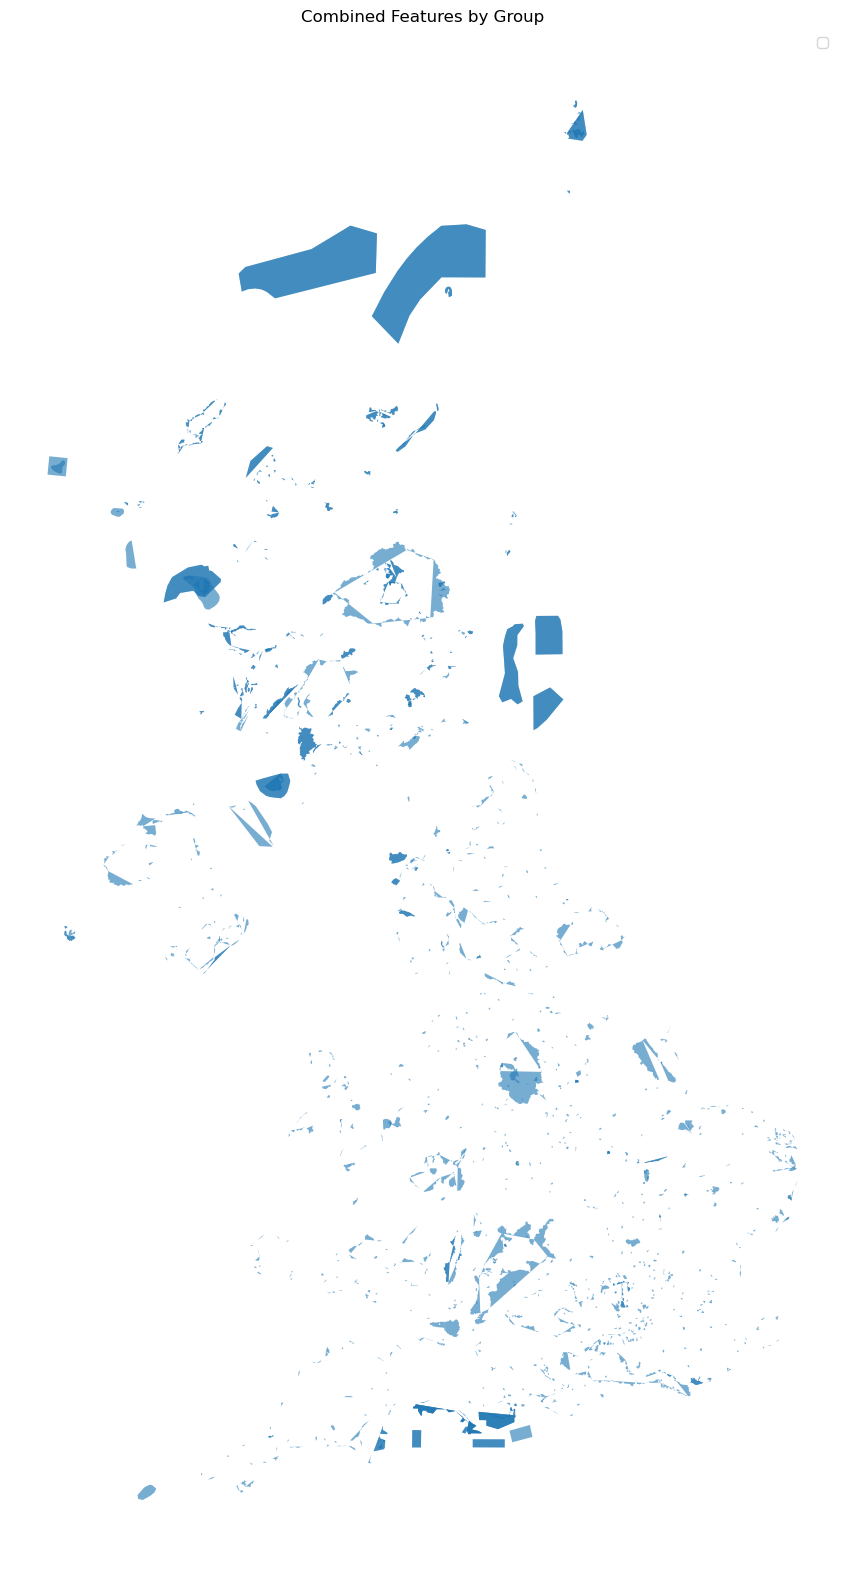

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

for name, gdf in features_1_filtered.items():
    gdf.plot(ax=ax, label=name, alpha=0.6)

plt.title("Combined Features by Group")
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot with a colormap to assign a different color to each feature
features_1_filtered.gdf_protected_areas.items().plot(ax=ax, cmap='tab20', legend=True)

# Add title and other plot settings
plt.title("Protected Areas with Unique Colors")
plt.axis('off')
plt.show()

In [ ]:
tags = {
  "type": "railwayStation"
}

stations = fetch_osm_features("England", tags, element_types=("nodes"))

print(stations.head())
print(f"Total features: {len(stations)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
stations.plot()